In [92]:
using HDF5
#using Plots
#using jlgr
using GRUtils
using Statistics
#using jlgr
#using Colors
#Plots.GRBackend()

In [93]:
filename = "BrioWu_0009.hdf5"
#filename = "BrioWu_START.hdf5"
#filename = "BrioWu_START_HUGEVISK.hdf5"
#filename = "BrioWu_START_sDIVnVSI.hdf5"
#filename = "BrioWu.hdf5"
pos = h5read(filename,"PartType0/Coordinates")
Bfl = h5read(filename,"PartType0/Bfield") 
Vel = h5read(filename,"PartType0/Velocities")
alp = h5read(filename,"PartType0/EPalpha")
bet = h5read(filename,"PartType0/EPbeta")
Ids = h5read(filename,"PartType0/ParticleIDs")
h   = h5read(filename,"PartType0/SmoothingLengths")
rho = h5read(filename,"PartType0/Densities")
divB = h5read(filename,"PartType0/divB")
head = h5readattr(filename,"Header")
print("Leyendo ",filename," at time: ",head["Time"],"\n")
x = pos[1,:]
y = pos[2,:]
z = pos[3,:]
Bx = Bfl[1,:]
By = Bfl[2,:]
Bz = Bfl[3,:]
Vx = Vel[1,:]
Vy = Vel[2,:]
Vz = Vel[3,:]

#idx= (x .< 1.0) 
#x[idx] = x[idx] .+ abs.(x[idx].-1.0)
#idx= (x .> 3.0) 
#x[idx] = x[idx] .- abs.(x[idx].-3.0)

v2 = Vx.*Vx.+Vy.*Vy.+Vz.*Vz
b2 = By.*By.+By.*By.+Bz.*Bz
b2 = bet
print(minimum(b2)," ",maximum(b2),"\n")
Npart=size(Ids,1)

Leyendo BrioWu_0009.hdf5 at time: [0.18]
-2.74847 -0.0017586137


589824

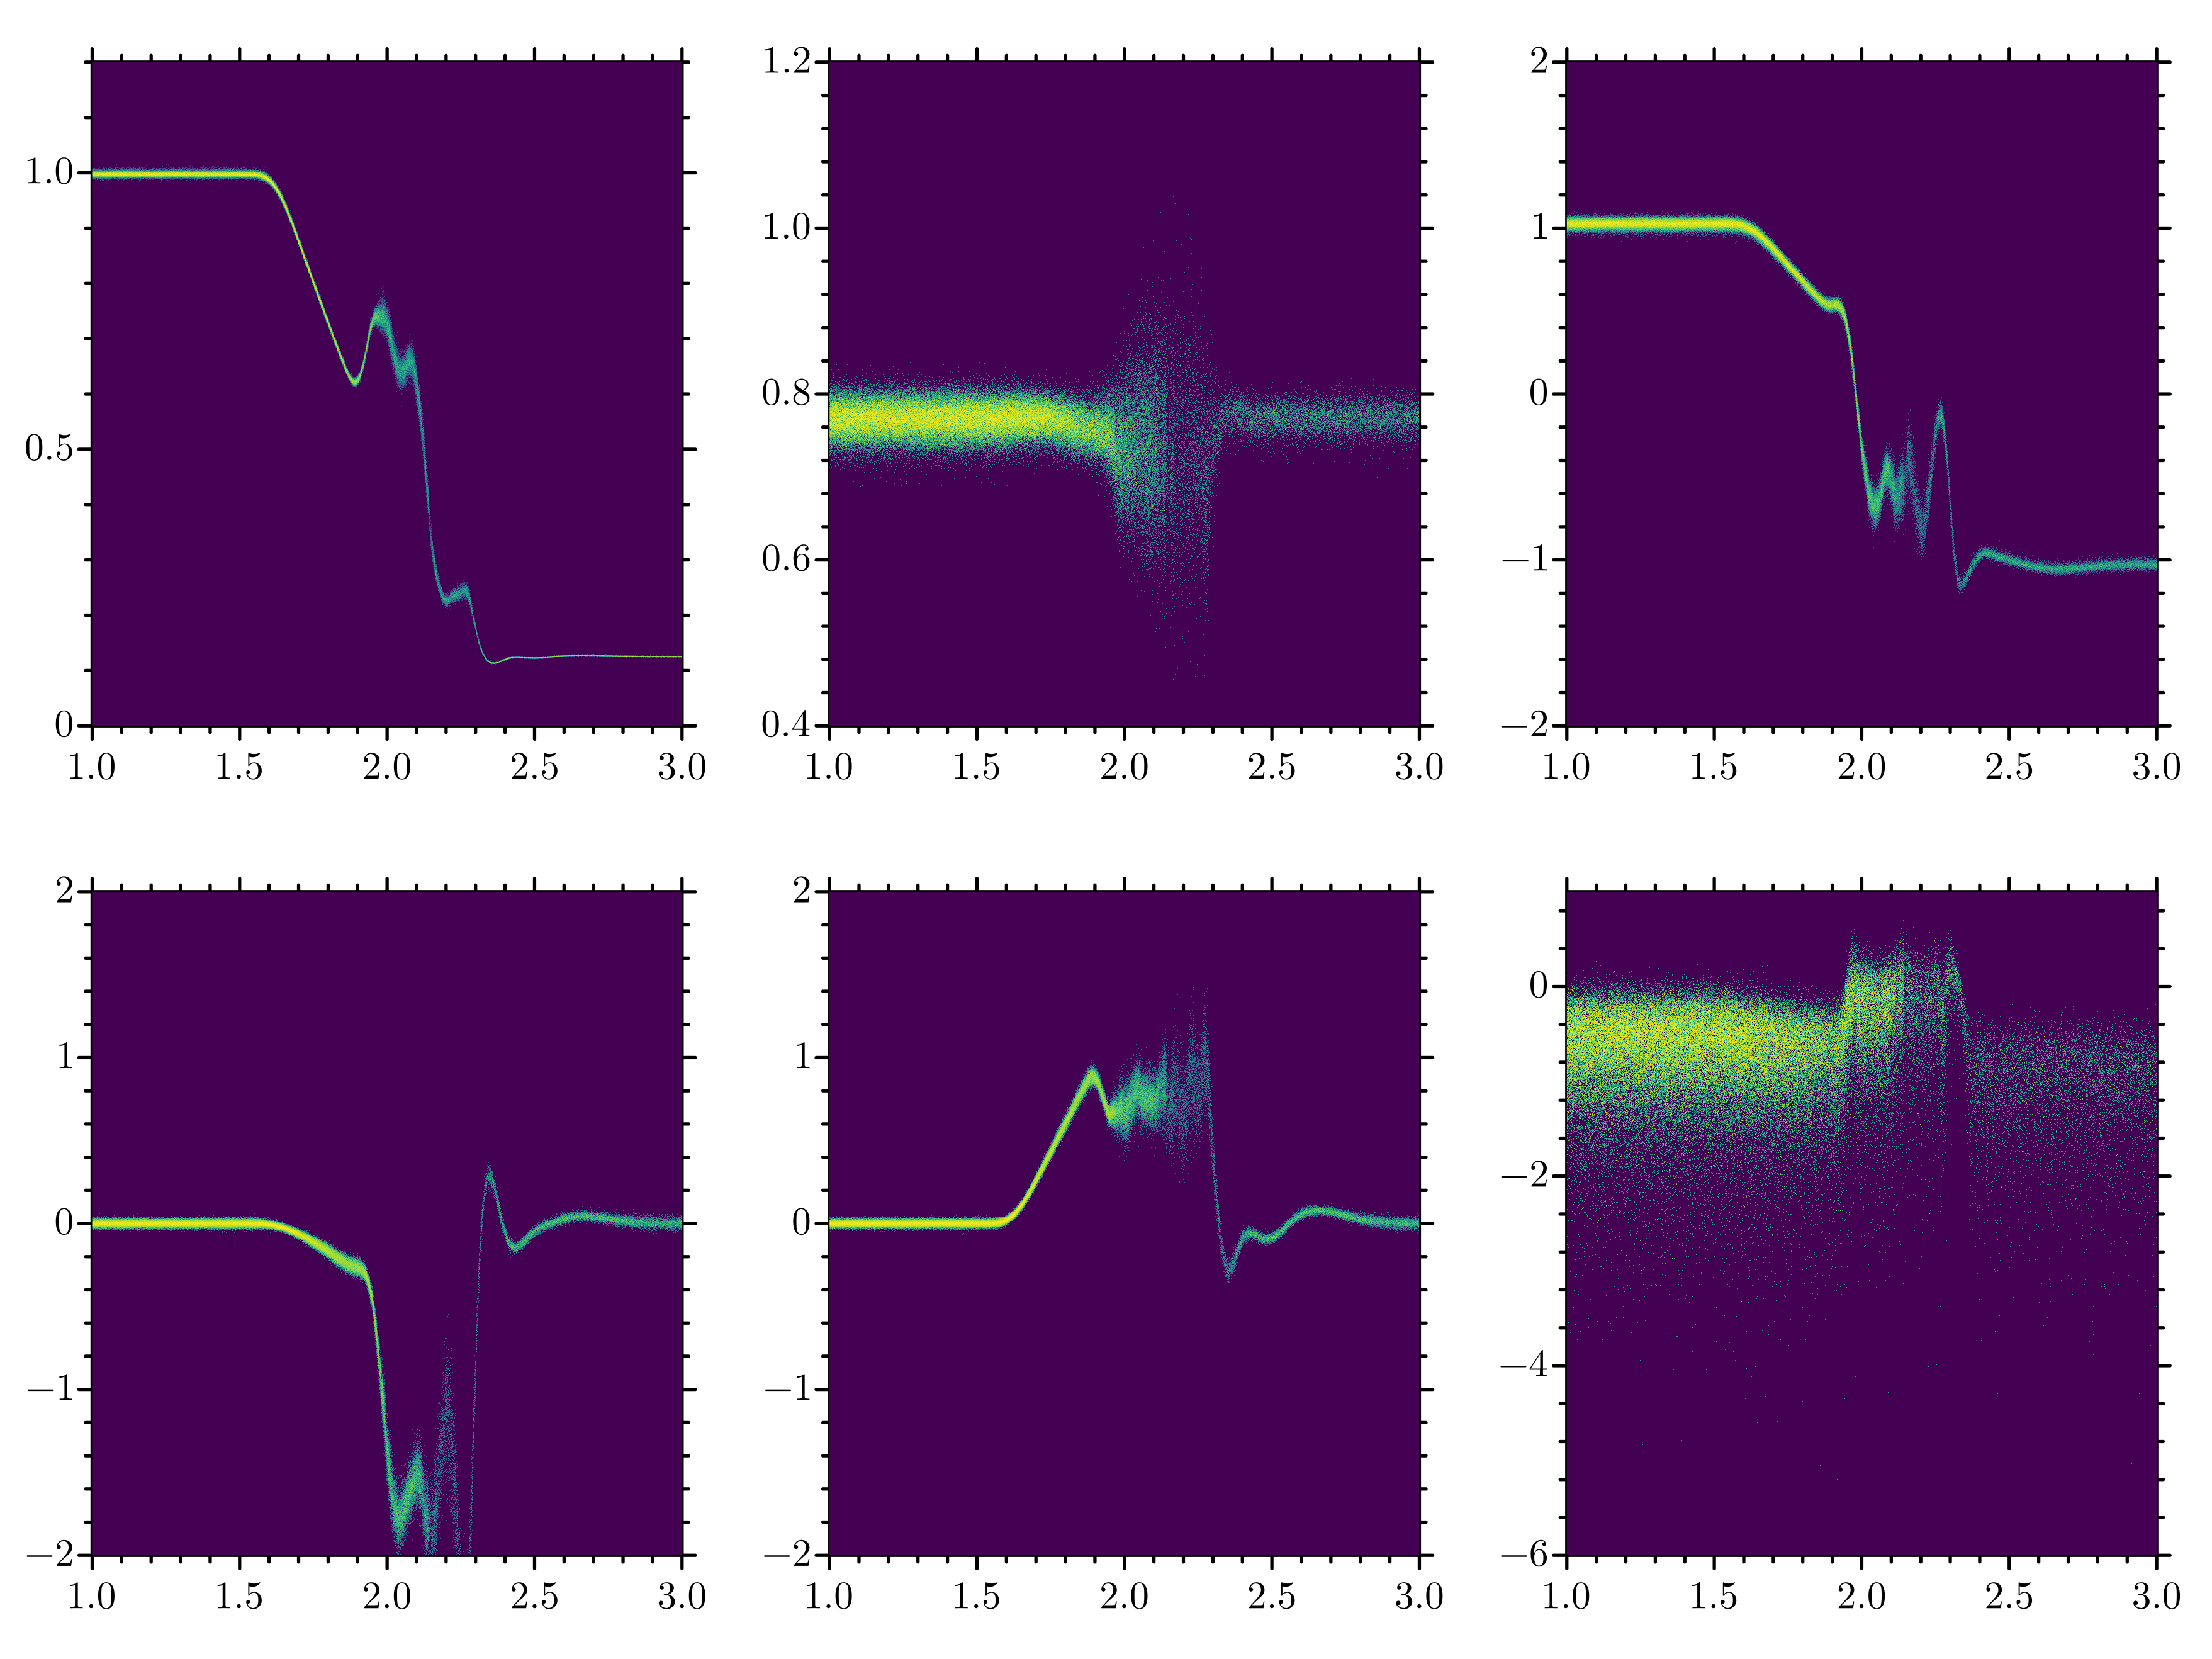

In [94]:
subplot(2, 3, 1)
shade(x,rho,xlim=(1,3),ylim=(0,1.2))
subplot(2, 3, 2)
shade(x,Bx,xlim=(1.0,3))
subplot(2, 3, 3)
shade(x,By,xlim=(1,3), ylim=(-2,2))
subplot(2, 3, 4)
shade(x,Vy,xlim=(1,3), ylim=(-2,2))
subplot(2, 3, 5)
shade(x,Vx,xlim=(1,3), ylim=(-2,2))
subplot(2, 3, 6)
shade(x,log10.(abs.(divB)),xlim=(1,3))

In [184]:
function read_snap(filename :: String)
    
    pos  = h5read(filename,"PartType0/Coordinates")
    Bfl  = h5read(filename,"PartType0/Bfield") 
    Vel  = h5read(filename,"PartType0/Velocities")
    alp  = h5read(filename,"PartType0/EPalpha")
    bet  = h5read(filename,"PartType0/EPbeta")
    divB = h5read(filename,"PartType0/divB")
    #Ids  = h5read(filename,"PartType0/ParticleIDs")
    h    = h5read(filename,"PartType0/SmoothingLengths")
    rho  = h5read(filename,"PartType0/Densities")
    head = h5readattr(filename,"Header")

    print("Leyendo ",filename," at time: ",head["Time"],"\n")
    x = pos[1,:]
    y = pos[2,:]
    z = pos[3,:]
    bx = Bfl[1,:]
    by = Bfl[2,:]
    bz = Bfl[3,:]
    Vx = Vel[1,:]
    Vy = Vel[2,:]
    Vz = Vel[3,:]
    
    v2 = Vx.*Vx.+Vy.*Vy.+Vz.*Vz
    b2 = by.*by.+by.*by.+bz.*bz
    
    Npart=size(b2,1)
        
    print("Min x:",minimum(x)," / Max x:",maximum(x),"\n")
    print("Min y:",minimum(y)," / Max y:",maximum(y),"\n")
    print("Min z:",minimum(z)," / Max z:",maximum(z),"\n")
    print("Min h:",minimum(h)," / Max h:",maximum(h),"\n")
    (Dict(:H => head, :x=>pos, :bfl=> Bfl, :b2=>b2, :v=>Vel, :v2=>v2, 
            :divB=>divB, :rho=>rho, :hsml=>h,:bet=> bet, :alp=> alp, Npart=> Npart))
end

function do_heat(data,what,Nmax)
    #Nmax=128
    #x=x.-minimum(x)
    #y=y.-minimum(y)
    #b2=data[what]
    b2=what
    Npart=size(b2,1)
    Lbox=1.0#+maximum(x)
    A = ones((Nmax, Nmax))*minimum(b2)
    grid = ones((Nmax, Nmax))
    #grid = [Set{Int}() for x=1:Nmax, y=1:Nmax];
    #insert(grid) = p -> push!(grid[trunc(Int, p.x/Lbox*Nmax), trunc(Int, p.y/Lbox*Nmax)], p.n);
    #foreach(insert(grid), data)
    x=data[:x][1,:]
    y=data[:x][2,:]
    for ind = 1:Npart
        i,j = trunc(Int, x[ind]/Lbox*Nmax+1), trunc(Int, y[ind]/Lbox*Nmax+1)
        A[i,j] += b2[ind]
        grid[i,j] += 1 
    end
    AA=log10.(A./grid)
    #AA=(A./grid)
    (AA)
end

function do_table(data,Nmax,minmax)
    #### Data
    x=data[:x][1,:]
    rho=data[:rho]
    divB=data[:divB]
    Bx=data[:bfl][1,:]
    By=data[:bfl][2,:]
    Bz=data[:bfl][3,:]
    Vx=data[:v][1,:]
    Vy=data[:v][2,:]
    Vz=data[:v][3,:]
    
    delta=(minmax[2]-minmax[1])/Nmax
    #### Out data
    xx=range(minmax[1],minmax[2],Nmax) # xx[1]>> min  xx[Nmax]>> max
    rrho =ones(Nmax-1,2)
    ddivB=ones(Nmax-1,2)
    BBx=ones(Nmax-1,2)
    BBy=ones(Nmax-1,2)
    BBz=ones(Nmax-1,2)
    VVx=ones(Nmax-1,2)
    VVy=ones(Nmax-1,2)
    VVz=ones(Nmax-1,2)
    
    for ind=1:Nmax-1
        idx=(x .>= xx[ind] .&& x .< xx[ind+1])
        rrho[ind,1] , rrho[ind,2]  = mean(rho[idx])  , std(rho[idx])
        ddivB[ind,1], ddivB[ind,2] = mean(divB[idx]) , std(divB[idx])
        BBx[ind,1]  , BBx[ind,2]   = mean(Bx[idx])   , std(Bx[idx])
        BBy[ind,1]  , BBy[ind,2]   = mean(By[idx])   , std(By[idx])
        BBz[ind,1]  , BBz[ind,2]   = mean(Bz[idx])   , std(Bz[idx])
        
        VVx[ind,1]  , VVx[ind,2]   = mean(Vx[idx])   , std(Vx[idx])
        VVy[ind,1]  , VVy[ind,2]   = mean(Vy[idx])   , std(Vy[idx])
        VVz[ind,1]  , VVz[ind,2]   = mean(Vz[idx])   , std(Vz[idx])
    end
    
    xx=range(minmax[1]+delta,minmax[2]-delta,Nmax-1) # xx[1]>> mean   xx[Nmax]>> mean
    
    (Dict(:x => xx, :rho=>rrho, :divB=>ddivB,
            :Bx=>BBx, :By=>BBy , :Bz=> BBz,
            :Vx=>VVx, :Vy=>VVy , :Vz=> VVz  ))
end

function do_6plot(gsnap)
    a=do_table(gsnap,128,[1,3])
    GRUtils.hold(false)
    subplot(1,1,1)
########## plot1
    subplot(2,3,1)
    plot(a[:x],a[:rho][:,1],ylim=(0,1.1),xlabel="X",ylabel="Rho")
    GRUtils.hold(true)
    errorbar(a[:x],a[:rho][:,1],a[:rho][:,2])
######## plot2
    subplot(2,3,2)
    plot(a[:x],a[:Bx][:,1],ylim=(-1.1,1.1),xlabel="X",ylabel="Bx/By")
    GRUtils.hold(true)
    errorbar(a[:x],a[:Bx][:,1],a[:Bx][:,2])
    plot(a[:x],a[:By][:,1])#,xlabel="X",ylabel="By")
    errorbar(a[:x],a[:By][:,1],a[:By][:,2])
####### plot3
    subplot(2,3,3)
    plot(a[:x],a[:Vx][:,1],ylim=(-0.4,1.0),xlabel="X",ylabel="Vx/Vz")
    GRUtils.hold(true)
    errorbar(a[:x],a[:Vx][:,1],a[:Vx][:,2])
    plot(a[:x],a[:Vz][:,1])
    errorbar(a[:x],a[:Vz][:,1],a[:Vz][:,2])
###### plot 4
    subplot(2,3,4)
    plot(a[:x],a[:Vy][:,1],xlabel="X",ylabel="Vy")
    GRUtils.hold(true)
    errorbar(a[:x],a[:Vy][:,1],a[:Vy][:,2])
###### plot 5
    subplot(2,3,5)
    plot(a[:x],abs.(a[:divB][:,1]),xlabel="X",ylabel="|divB|")
    GRUtils.hold(true)
    errorbar(a[:x],abs.(a[:divB][:,1]),a[:divB][:,2])
end

do_6plot (generic function with 1 method)

Leyendo BrioWu_0011.hdf5 at time: [0.2]
Min x:1.4587066038589814e-6 / Max x:3.9999985446936543
Min y:3.078627223196409e-6 / Max y:0.9999999527430662
Min z:8.073410266984382e-7 / Max z:0.9999999192423129
Min h:0.020598795 / Max h:0.04196451


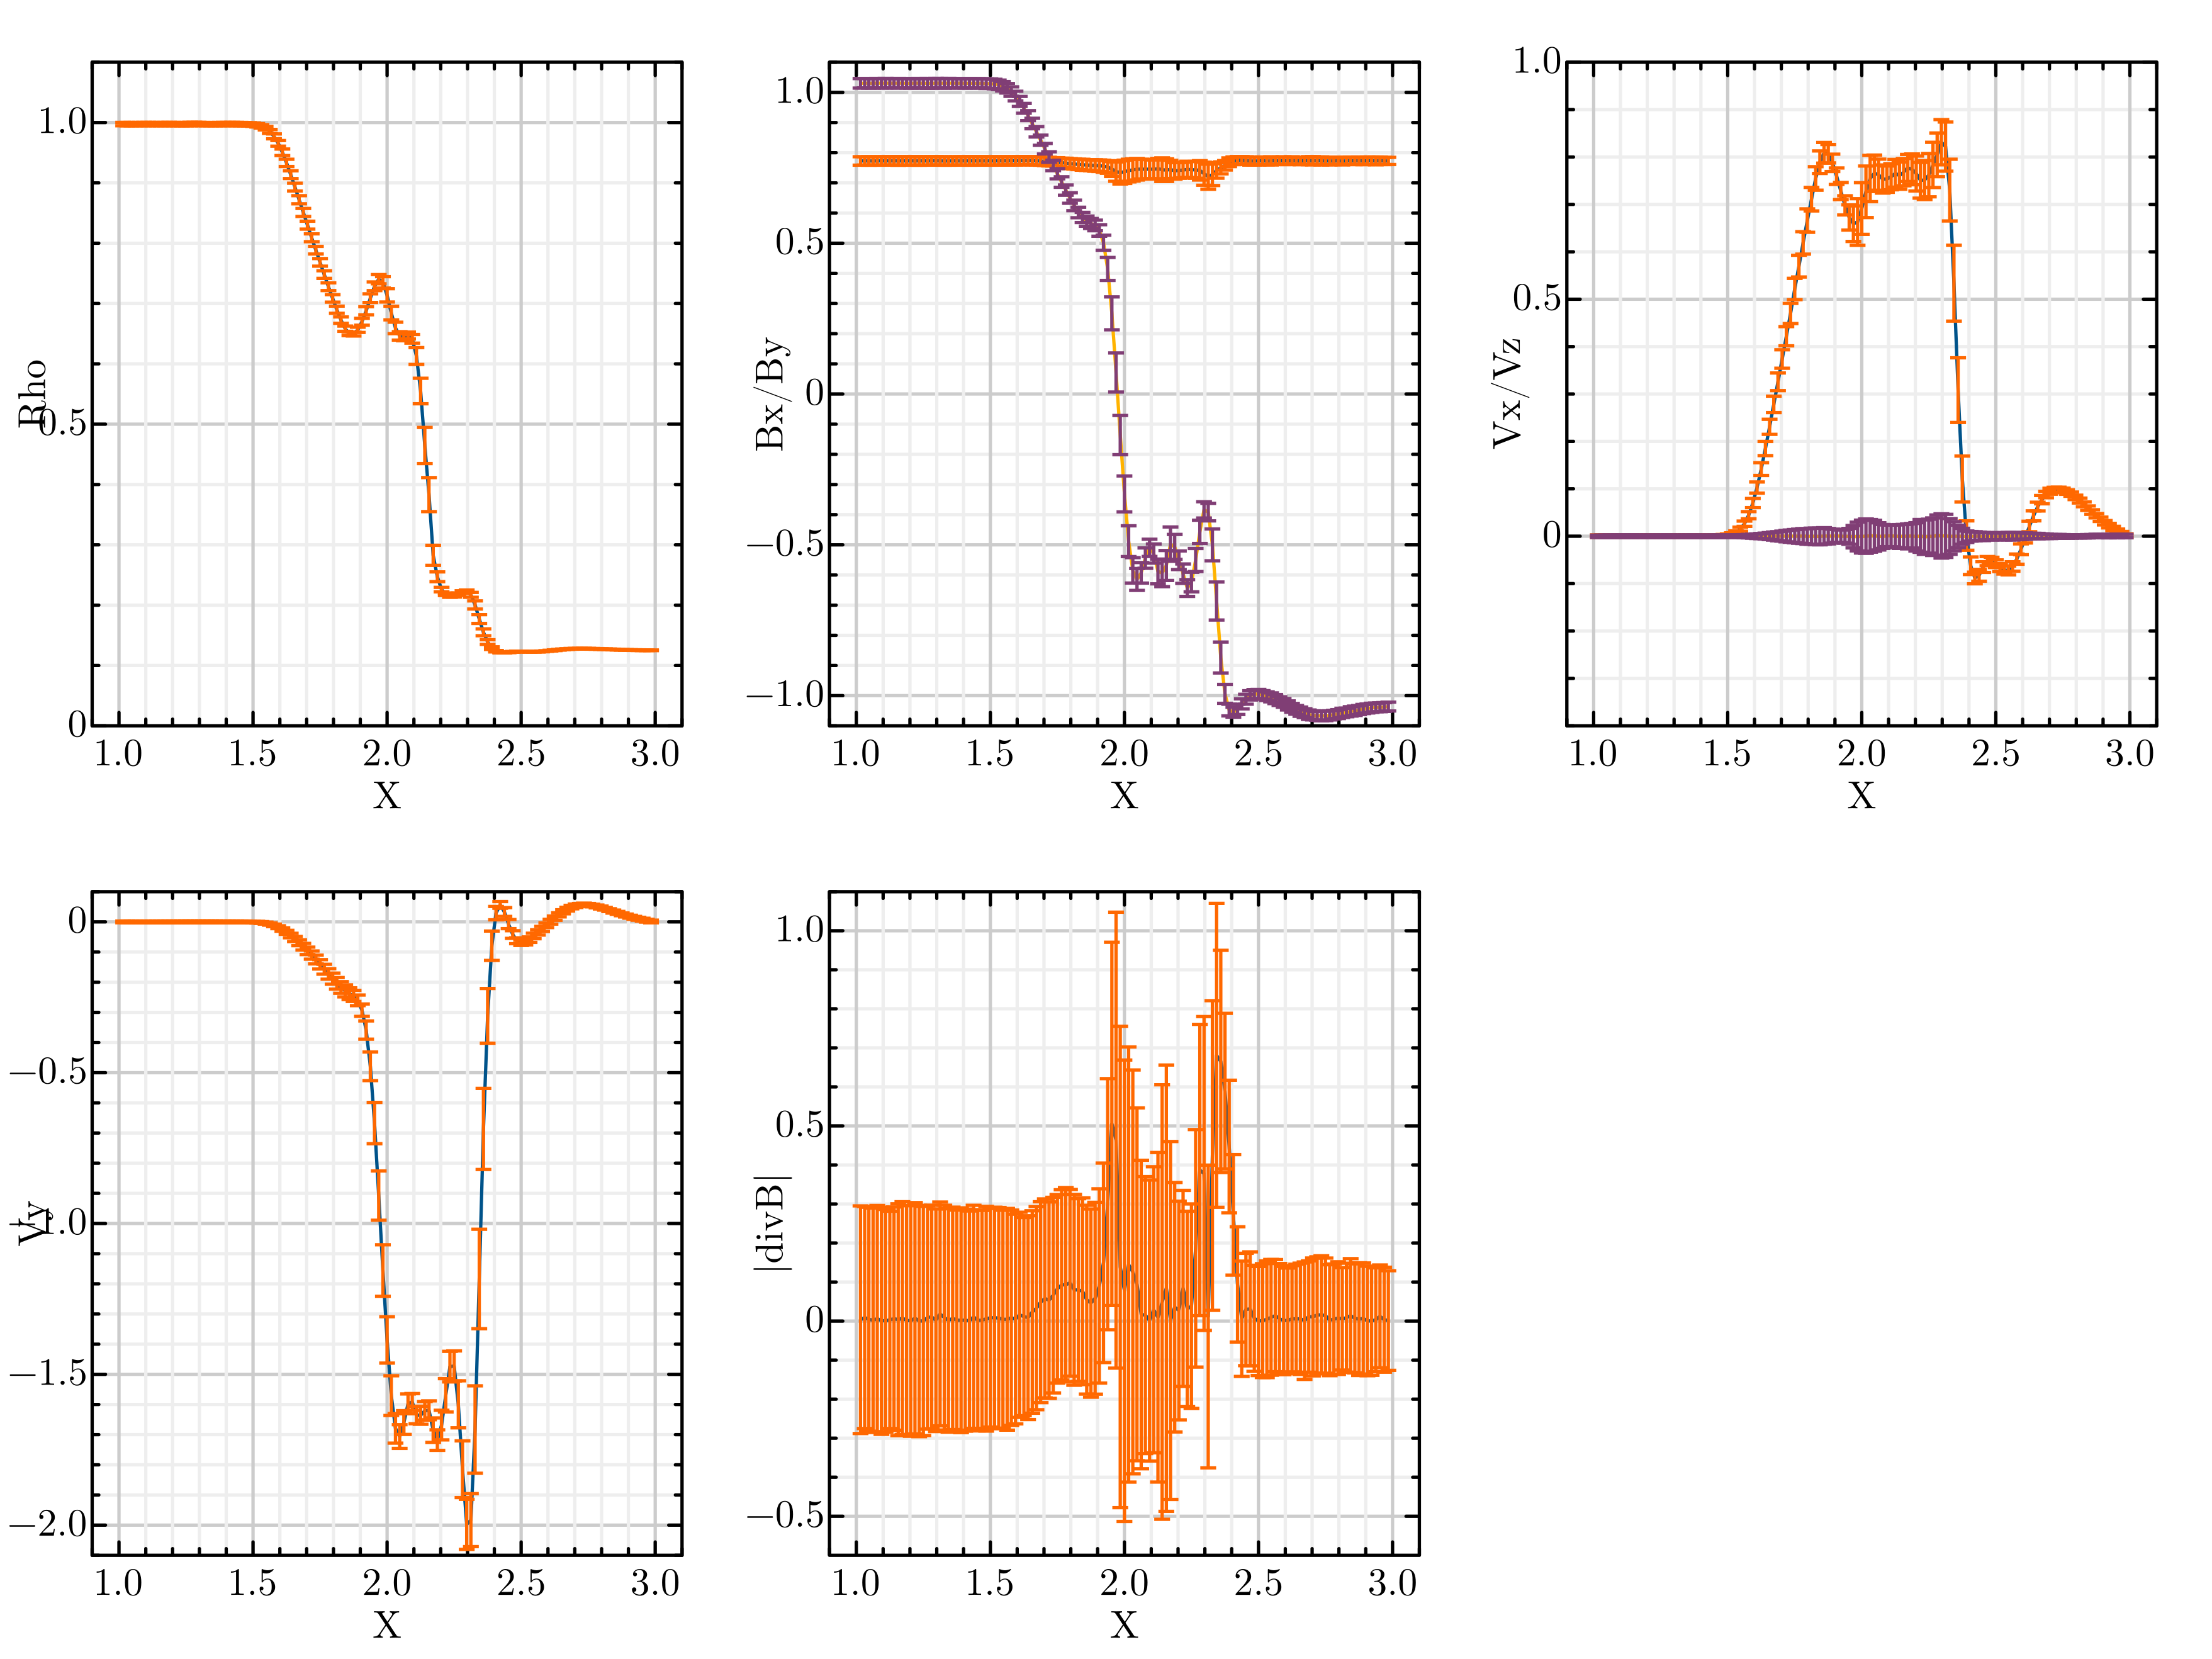

In [189]:
gsnap=read_snap("BrioWu_0011.hdf5")
do_6plot(gsnap)

Leyendo BrioWu_anda.hdf5 at time: [0.2]
Min x:5.266680615407962e-6 / Max x:3.9999877663322123
Min y:5.1905859201895055e-6 / Max y:0.9999997949592216
Min z:1.6067632357952277e-7 / Max z:0.9999998053308246
Min h:0.020570364 / Max h:0.042889915


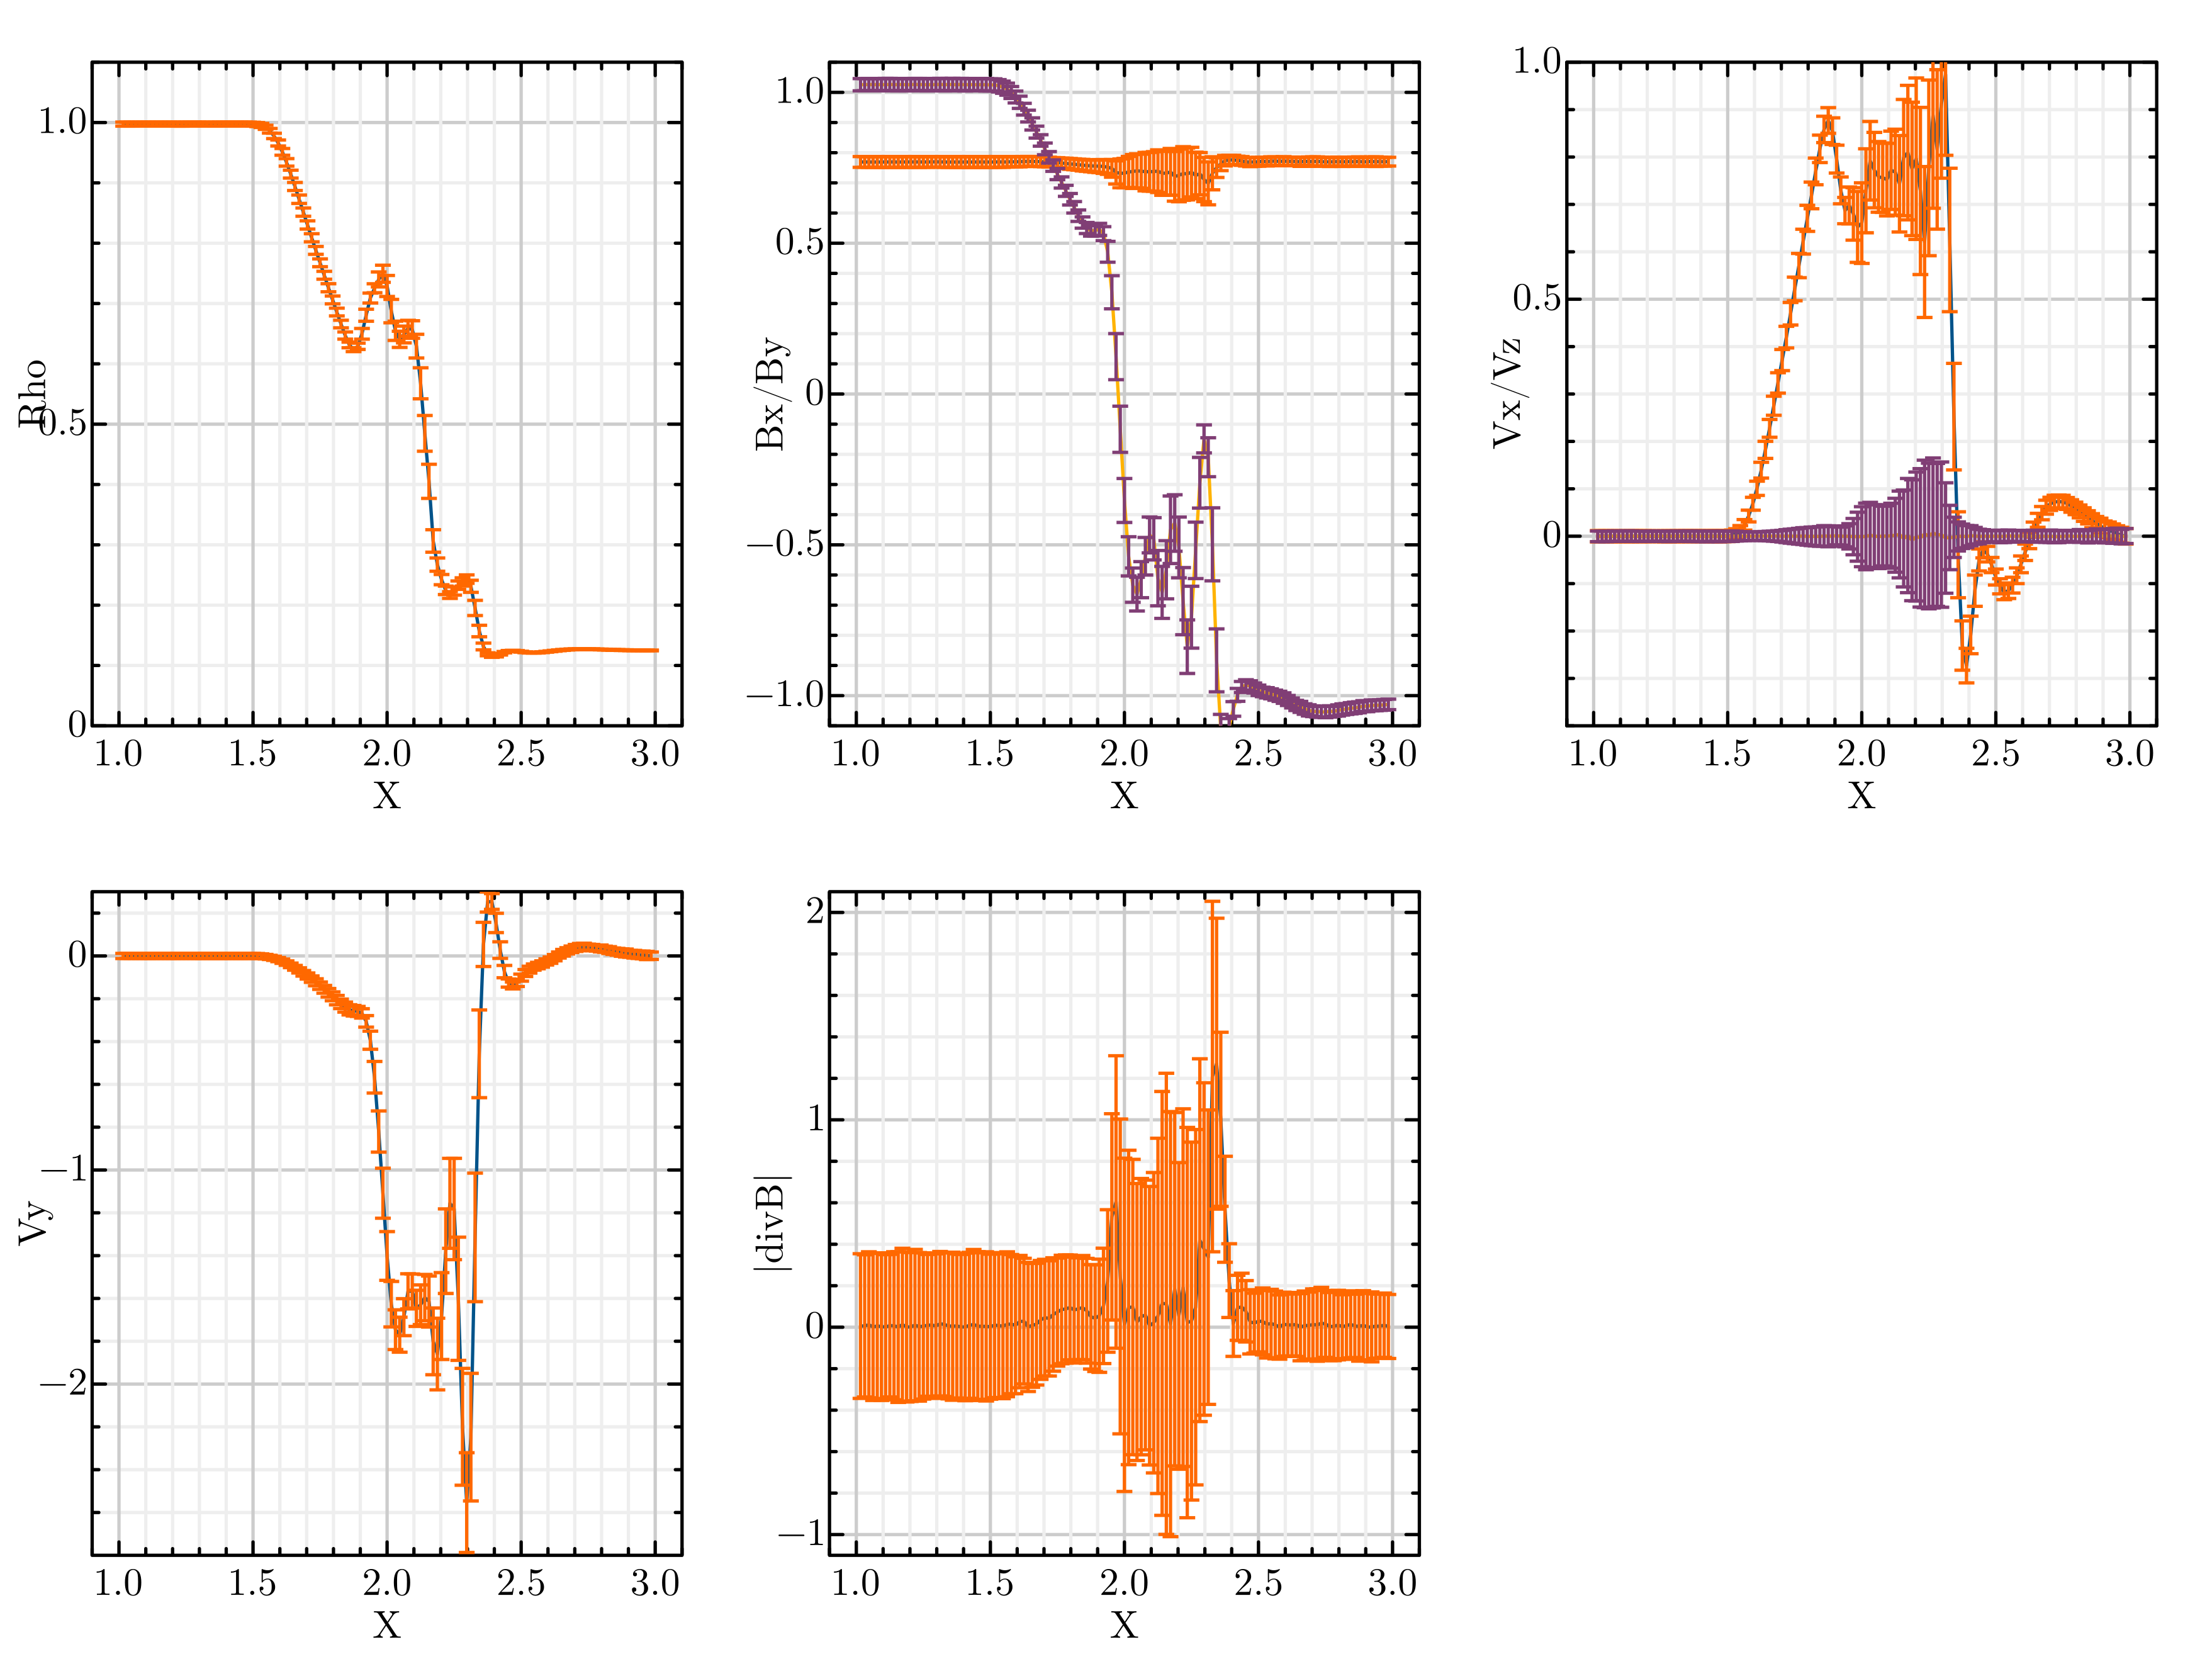

In [188]:
gsnap=read_snap("BrioWu_anda.hdf5")
do_6plot(gsnap)

In [182]:
gsnap=read_snap("BrioWu_anda.hdf5")
x=gsnap[:x][1,:]
rho=gsnap[:rho]
Bx=gsnap[:bfl][1,:]
By=gsnap[:bfl][2,:]
Bz=gsnap[:bfl][3,:]
divB=gsnap[:divB]
Vx=gsnap[:v][1,:]
Vy=gsnap[:v][2,:]
Vz=gsnap[:v][3,:]

Leyendo BrioWu_anda.hdf5 at time: [0.2]
Min x:5.266680615407962e-6 / Max x:3.9999877663322123
Min y:5.1905859201895055e-6 / Max y:0.9999997949592216
Min z:1.6067632357952277e-7 / Max z:0.9999998053308246
Min h:0.020570364 / Max h:0.042889915


589824-element Vector{Float32}:
 -0.01644572
 -0.0008204418
  0.03671752
  0.03905032
  0.07216267
 -0.0078885285
  0.01484031
 -0.023452414
 -0.026864612
  0.036762975
 -0.052466407
  0.038070485
  0.0066892225
  ⋮
 -0.035040125
 -0.115111776
  0.021554334
  0.041448347
 -0.025606686
 -0.020205582
  0.030725118
 -0.0068928306
 -0.1271824
 -0.033047926
  0.12448765
 -0.044808824

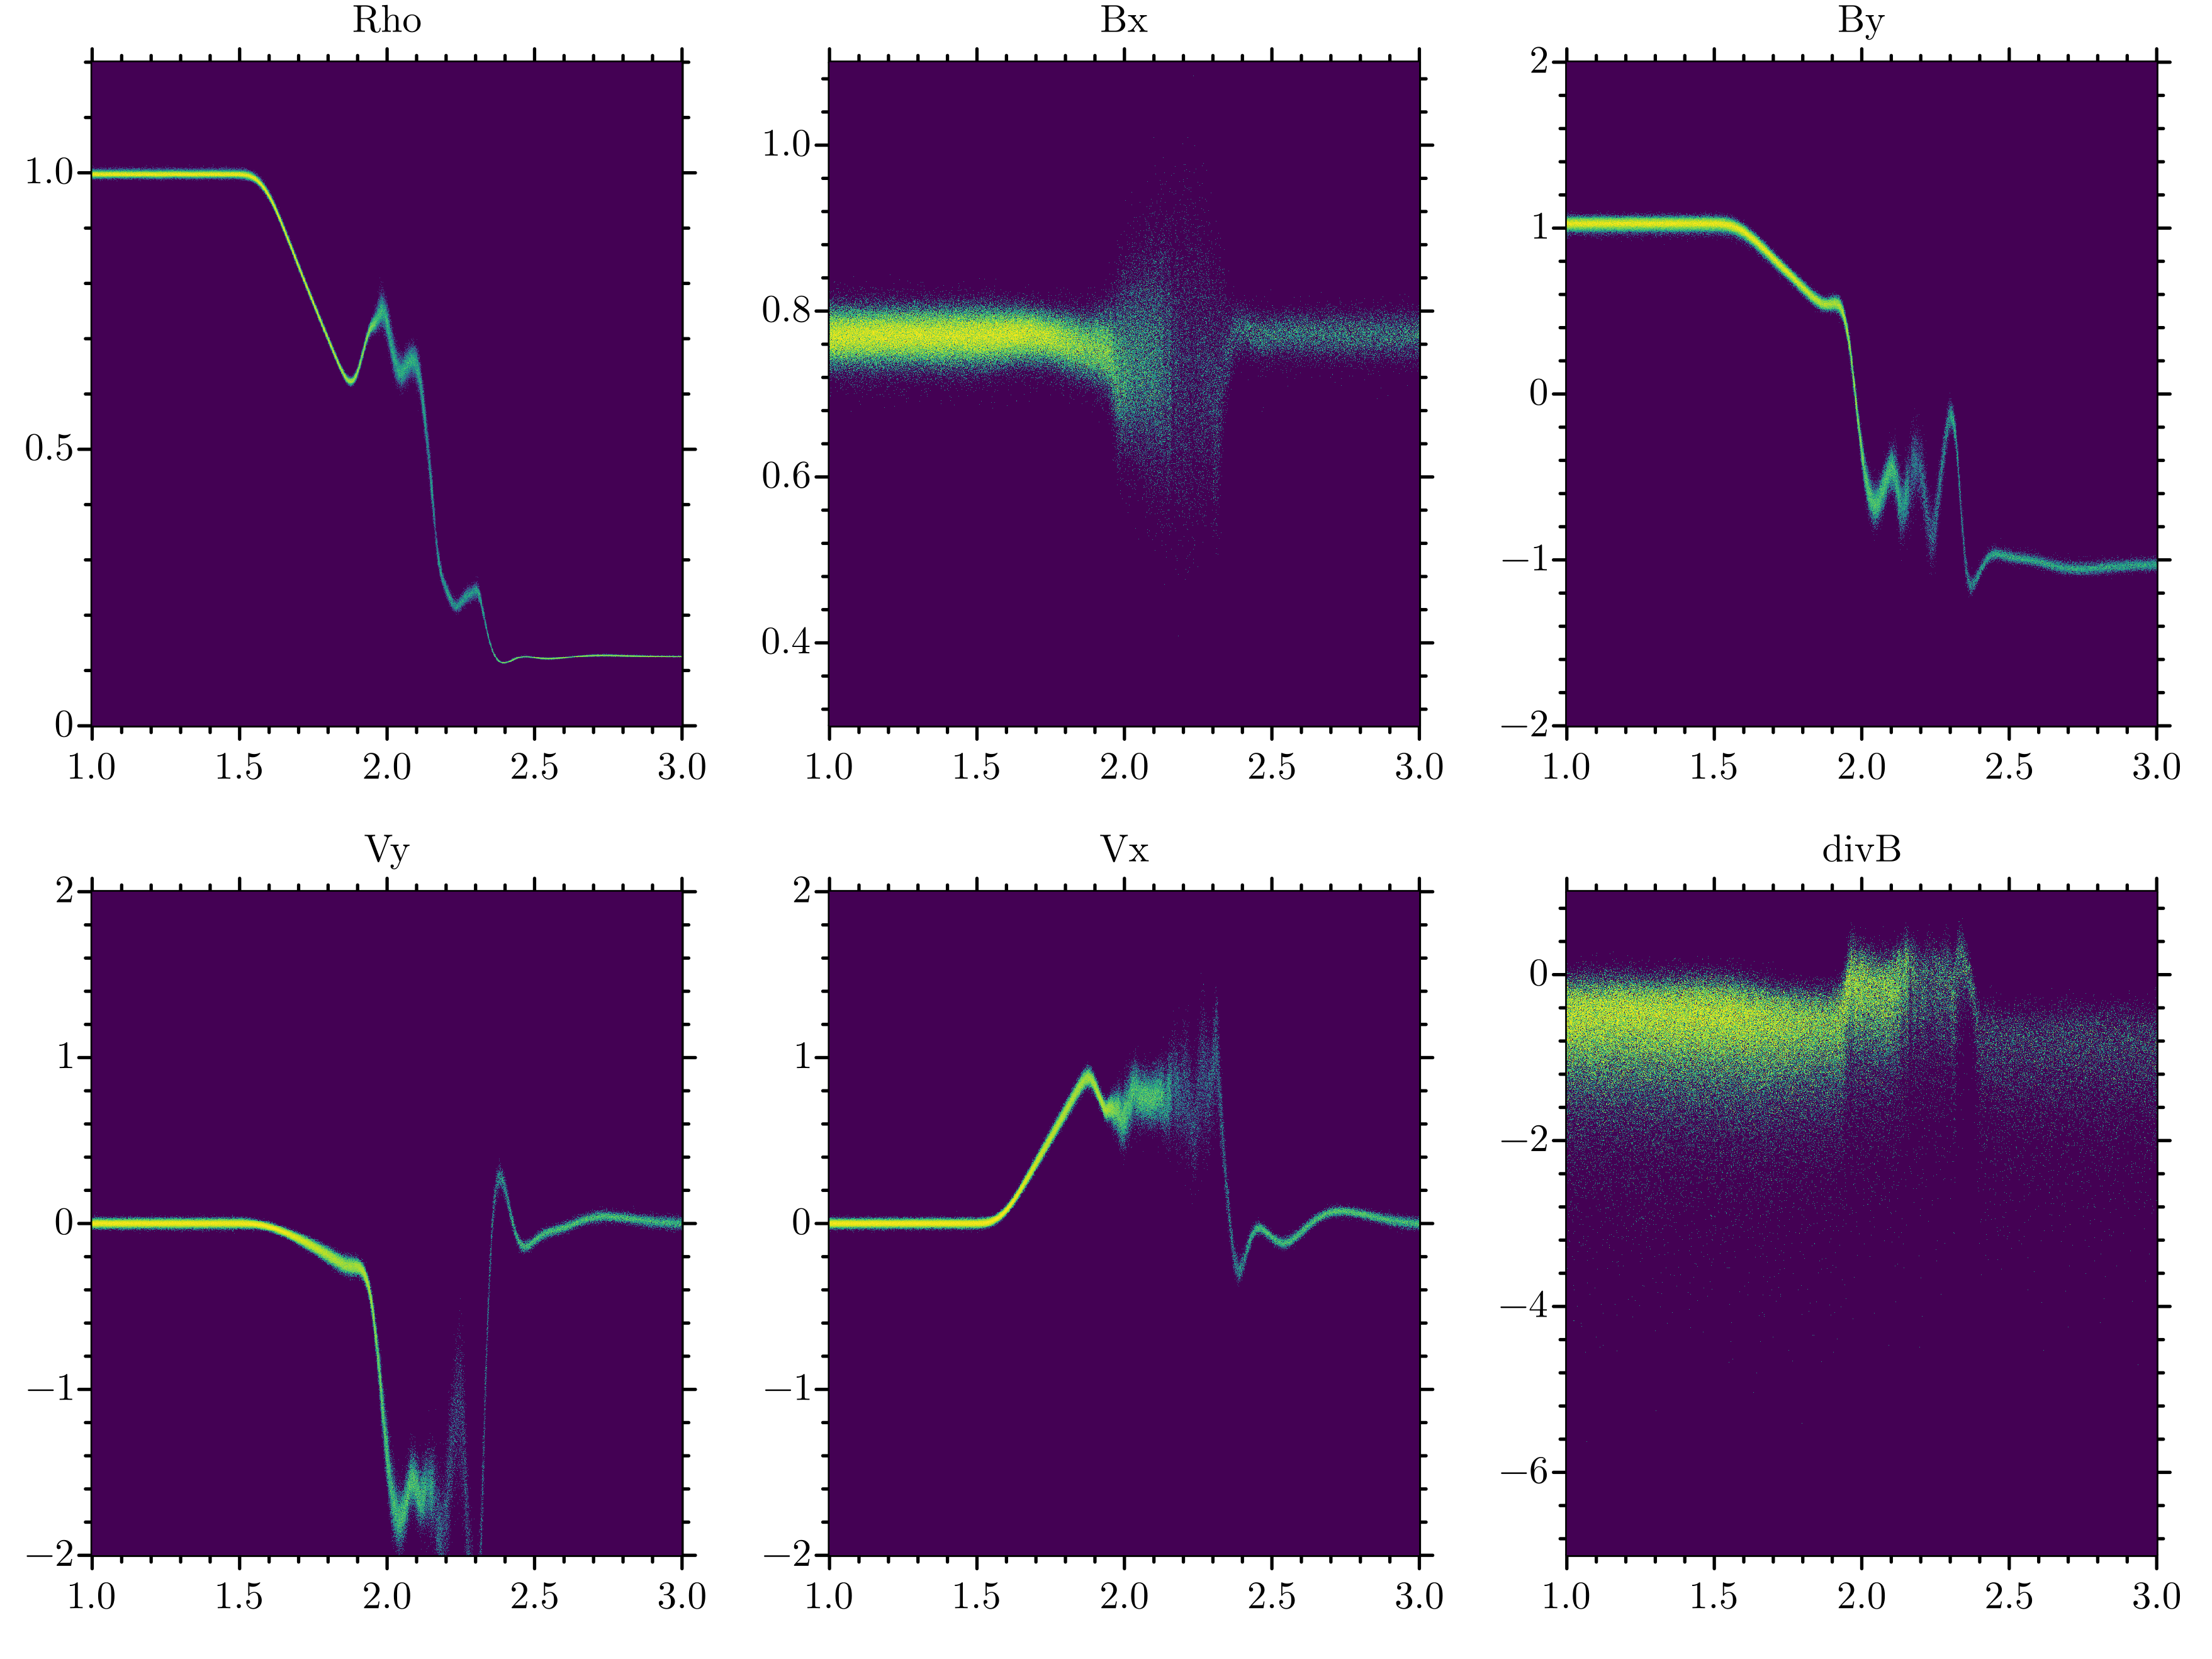

In [156]:

subplot(2, 3, 1)
shade(x,rho,xlim=(1,3),ylim=(0,1.2),title="Rho")
subplot(2, 3, 2)
shade(x,Bx,xlim=(1.0,3),title="Bx")
subplot(2, 3, 3)
shade(x,By,xlim=(1,3), ylim=(-2,2),title="By")
subplot(2, 3, 4)
shade(x,Vy,xlim=(1,3), ylim=(-2,2),title="Vy")
subplot(2, 3, 5)
shade(x,Vx,xlim=(1,3), ylim=(-2,2),title="Vx")
subplot(2, 3, 6)
shade(x,log10.(abs.(divB)),xlim=(1,3),title="divB")